# WTDTA1 Debug

Check WTDTA1 modeling.

References:
- [ANDES Doc - WTDTA1](https://docs.andes.app/en/v1.9.3/groupdoc/RenGovernor.html#wtdta1)
- [ANDES Implementation - WTDTA1, as of v1.9.3](https://github.com/CURENT/andes/blob/0c9b483434d672c11ad45c85a1588c596eb23541/andes/models/renewable/regca1.py)
- [PowerWorld - WTDTA1](https://www.powerworld.com/WebHelp/Content/TransientModels_HTML/Governor%20WTDTA1.htm)

In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt

import andes

In [2]:
!andes misc --version

Python  3.12.0
andes   1.9.3.post7+g967a6b80
numpy   2.0.2
kvxopt  1.3.2.1
sympy   1.13.3
scipy   1.13.1
pandas  2.2.2
numba   0.60.0


In [3]:
%matplotlib inline

In [4]:
andes.config_logger(20)

We load the same case file into three systems, `s0`, `s1` and `s2`, for comparison.

Case0 `s0` is used as the base case.

In case1 `s1`, we add a partial **WT2G** composed of:

1. **Electrical control chain**: `REPCA1 (RenPlant)` -> `REECA1 (RenExciter)` -> `REGCA1 (RenGen)`
2. **Mechanical chain**: `WTPTA1 (RenPitch)` -> `WTARA1 (RenAerodynamic)` -> `WTDTA1 (RenGovernor)` -> `REECA1 (RenExciter)`

where WTPTA1 and WTARA1 are skipped for now.

In case2 `s2`, we add a **simplified WT2G model**, omitting pitch and aerodynamic detail:

1. `REPCA1` → `REECA1` → `REGCA1`
2. `WTDS (RenGovernor)` → `REECA1`

In this context, arrows (`→`) indicate signal flow.

In [5]:
s0 = andes.load(andes.get_case('ieee14/ieee14_gentrip.xlsx'),
                setup=False,
                no_output=True,
                default_config=True)
s1 = andes.load(andes.get_case('ieee14/ieee14_gentrip.xlsx'),
                setup=False,
                no_output=True,
                default_config=True)
s2 = andes.load(andes.get_case('ieee14/ieee14_gentrip.xlsx'),
                setup=False,
                no_output=True,
                default_config=True)

for ss in [s0, s1, s2]:
    # Set SynGen with different Sn for debugging purpose
    syg = s1.SynGen.get_all_idxes()
    ss.SynGen.alter(src='Sn', idx=syg, value=100 *
                    np.array(range(1, len(syg)+1)))

    # Turn off TGOV1 lower limit for debugging purpose
    tg = s1.TurbineGov.get_all_idxes()
    ss.TurbineGov.alter(src='VMIN', idx=tg, value=0.0)

Working directory: "/Users/jinningwang/work/demo/demo"
> Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Parsing input file "/Users/jinningwang/work/andes/andes/cases/ieee14/ieee14_gentrip.xlsx"...
Input file parsed in 0.2768 seconds.
Working directory: "/Users/jinningwang/work/demo/demo"
> Reloaded generated Python code of module "pycode".
Parsing input file "/Users/jinningwang/work/andes/andes/cases/ieee14/ieee14_gentrip.xlsx"...
Input file parsed in 0.0225 seconds.
Working directory: "/Users/jinningwang/work/demo/demo"
> Reloaded generated Python code of module "pycode".
Parsing input file "/Users/jinningwang/work/andes/andes/cases/ieee14/ieee14_gentrip.xlsx"...
Input file parsed in 0.0232 seconds.


Replace ``GENROU_3`` with wind generation.

In [6]:
stg_idx = 3
syg_idx = s1.SynGen.find_idx(keys='gen', values=[stg_idx])[0]

# common models
for ss in [s1, s2]:
    # Turn off the corresponding SynGen
    ss.SynGen.alter(src='u', value=0, idx=syg_idx)

    # Add REGCA1
    ss.add(model='REGCA1',
           param_dict=dict(u=1, idx='REGCA1_1',
                           gen=stg_idx,
                           bus=ss.SynGen.get(src='bus', idx=syg_idx),
                           Sn=ss.SynGen.get(src='Sn', idx=syg_idx),
                           gammap=ss.SynGen.get(src='gammap', idx=syg_idx),
                           gammaq=ss.SynGen.get(src='gammaq', idx=syg_idx)))

    # Add REECA1
    ss.add(model='REECA1',
           param_dict=dict(u=1, idx='REECA1_1',
                           reg='REGCA1_1',
                           PFFLAG=0, VFLAG=0, QFLAG=0, PFLAG=0, PQFLAG=0,
                           Vdip=0.8, Vup=1.2, Trv=0.02, dbd1=-0.1, dbd2=0.1,
                           Kqv=20, Thld=-2, Thld2=1, Vref1=1, Imax=10,
                           Kqp=1, Kqi=0, Kvp=1, Kvi=0))

    # Add REPCA1
    # manually assign mandatory param `line`
    ree = 'REECA1_1'
    reg = ss.REECA1.get(src='reg', attr='v', idx=[ree])
    bus = ss.REGCA1.get(src='bus', attr='v', idx=[reg])
    line1 = ss.Line.find_idx(keys='bus1', values=bus,
                             allow_none=True, default=None)
    line2 = ss.Line.find_idx(keys='bus2', values=bus,
                             allow_none=True, default=None)
    line = []
    for l1, l2 in zip(line1, line2):
       if l1 is not None:
           line.append(l1)
       elif l2 is not None:
           line.append(l2)
       else:
           line.append(None)

    ss.add(model='REPCA1',
           param_dict=dict(u=1, idx='REPCA1_1',
                           ree='REECA1_1', line=line[0],
                           VCFlag=0, RefFlag=0, Fflag=0, PLflag=0))

# for case1, add WTDTA1
s1.add(model='WTDTA1',
       param_dict=dict(u=1, idx='WTDTA1_1', ree='REECA1_1',
                       DAMP=0, H=3, Htfrac=0.5, Dshaft=1))

# for case2, add WTDS
s2.add(model='WTDS',
       param_dict=dict(u=1, idx='WTDS_1', ree='REECA1_1',
                       H=3, D=0, w0=1))

'WTDS_1'

Set them up

In [7]:
for ss in [s0, s1, s2]:
    ss.setup()

System internal structure set up in 0.0153 seconds.
System internal structure set up in 0.0143 seconds.
System internal structure set up in 0.0135 seconds.


In [8]:
s1.WTDTA1.as_df()

,idx,u,name,ree,H,DAMP,Htfrac,Freq1,Dshaft,w0
uid,,,,,,,,,,
0,WTDTA1_1,1.0,WTDTA1_1,REECA1_1,9.0,0.0,1.5,1.0,3.0,1.0


In case1, Htfrac is 1.5 after per unit conversion, but it should be a fraction of the total inertia, in the range [0, 1]

Run PFlow

In [9]:
for ss in [s0, s1, s2]:
    ss.PQ.config.p2p = 1
    ss.PQ.config.q2q = 1
    ss.PQ.config.p2z = 0
    ss.PQ.config.q2z = 0

    ss.PFlow.run()

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0086 seconds.
0: |F(x)| = 0.5605182134
1: |F(x)| = 0.006202200332
2: |F(x)| = 5.819382825e-06
3: |F(x)| = 6.964193111e-12
Converged in 4 iterations in 0.0029 seconds.
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0044 seconds.
0: |F(x)| = 0.5605182134
1: |F(x)| = 0.006202200332
2: |F(x)| = 5.819382825e-06
3: |F(x)| = 6.964193111e-12
Converged in 4 iterations in 0.0025 seconds.
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each i

Init TDS

In [10]:
s1.TGOV1.as_df()

,idx,u,name,syn,Tn,wref0,R,VMAX,VMIN,T1,T2,T3,Dt
uid,,,,,,,,,,,,,
0,TGOV1_1,1.0,TGOV1_1,GENROU_1,0.0,1.0,0.050000,1.05,0.0,0.05,1.0,2.1,0.0
1,TGOV1_2,1.0,TGOV1_2,GENROU_2,0.0,1.0,0.025000,2.40,0.0,0.10,1.0,2.1,0.0
2,TGOV1_3,1.0,TGOV1_3,GENROU_3,0.0,1.0,0.016667,3.60,0.0,0.10,1.0,2.1,0.0
3,TGOV1_4,1.0,TGOV1_4,GENROU_4,0.0,1.0,0.012500,4.20,0.0,0.05,1.0,2.1,0.0
4,TGOV1_5,1.0,TGOV1_5,GENROU_5,0.0,1.0,0.010000,5.25,0.0,0.05,1.0,2.1,0.0


In [11]:
for ss in [s0, s1, s2]:
    _ = ss.TDS.init()

Initialization for dynamics completed in 0.0173 seconds.
Initialization was successful.
GENROU (vf range) out of typical lower limit.

   idx    | values | limit
----------+--------+------
 GENROU_3 | 0      | 1    


Initialization for dynamics completed in 0.0262 seconds.
Initialization was successful.
GENROU (vf range) out of typical lower limit.

   idx    | values | limit
----------+--------+------
 GENROU_3 | 0      | 1    


Initialization for dynamics completed in 0.0265 seconds.
Initialization was successful.


Run EIG

In [12]:
# NOTE: manually set the file name otherwise they
# will be overwritten as their file names are the same
s0.files.eig = 'case0_eig.txt'
s1.files.eig = 'case1_eig.txt'
s2.files.eig = 'case2_eig.txt'

_ = s0.EIG.run()
s0.EIG.report()

_ = s1.EIG.run()
s1.EIG.report()

_ = s2.EIG.run()
s2.EIG.report()


-> Eigenvalue Analysis:
4 states are associated with zero time constants. 
  Positive       0
  Zeros          1
  Negative      62
Eigenvalue analysis finished in 0.0031 seconds.
Report saved to "case0_eig.txt".

-> Eigenvalue Analysis:
4 states are associated with zero time constants. 
  Positive       3
  Zeros          8
  Negative      79
Eigenvalue analysis finished in 0.0045 seconds.
Report saved to "case1_eig.txt".

-> Eigenvalue Analysis:
4 states are associated with zero time constants. 
Singular matrix. Case is not solvable
  Positive       0
  Zeros          7
  Negative      81
Eigenvalue analysis finished in 0.0073 seconds.
Report saved to "case2_eig.txt".


Run TDS

In [13]:
for ss in [s0, s1, s2]:
    ss.TDS.config.criteria = 0
    ss.TDS.config.no_tqdm = 1
    ss.TDS.config.tf = 80

    ss.TDS.run()


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-80 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


<Toggle Toggler_1>: GENROU.GENROU_2 status changed to 0 at t=1.0 sec.


Simulation to t=80.00 sec completed in 2.8023 seconds.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-80 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


<Toggle Toggler_1>: GENROU.GENROU_2 status changed to 0 at t=1.0 sec.


Simulation to t=80.00 sec completed in 7.2633 seconds.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-80 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


<Toggle Toggler_1>: GENROU.GENROU_2 status changed to 0 at t=1.0 sec.


Simulation to t=80.00 sec completed in 7.1923 seconds.


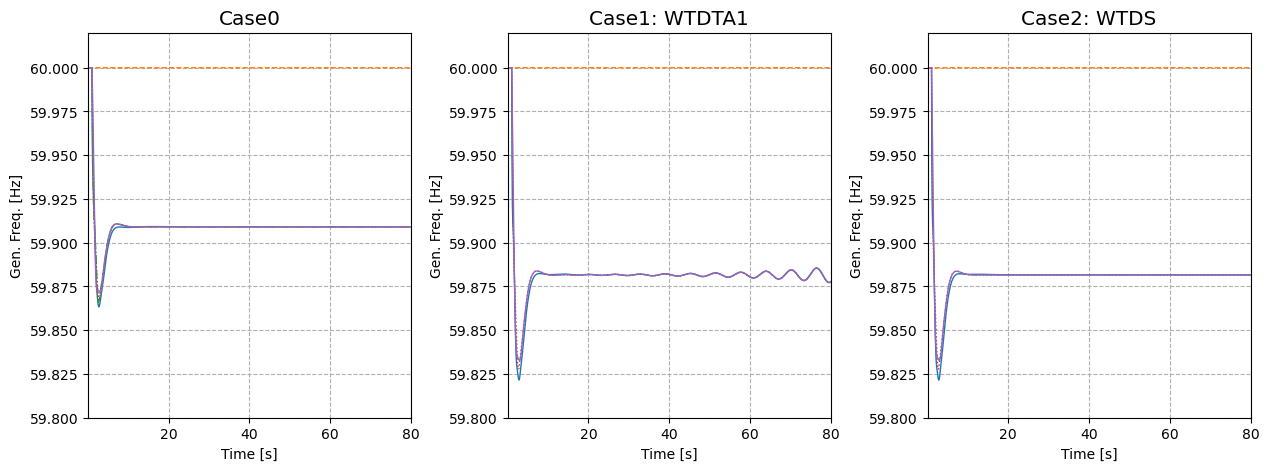

In [14]:
plt.style.use('default')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.subplots_adjust(wspace=0.3)

ymin, ymax = 59.8, 60.02

_ = s0.TDS.plt.plot(s0.GENROU.omega,
                    ytimes=s0.config.freq,
                    ymin=ymin, ymax=ymax,
                    grid=True, show=False,
                    legend=False,
                    ylabel='Gen. Freq. [Hz]',
                    title='Case0',
                    fig=fig, ax=ax[0],)

_ = s1.TDS.plt.plot(s1.GENROU.omega,
                    ytimes=s1.config.freq,
                    ymin=ymin, ymax=ymax,
                    grid=True, show=False,
                    legend=False,
                    ylabel='Gen. Freq. [Hz]',
                    title='Case1: WTDTA1',
                    fig=fig, ax=ax[1],)

_ = s2.TDS.plt.plot(s2.GENROU.omega,
                    ytimes=s2.config.freq,
                    ymin=ymin, ymax=ymax,
                    grid=True, show=False,
                    legend=False,
                    ylabel='Gen. Freq. [Hz]',
                    title='Case2: WTDS',
                    fig=fig, ax=ax[2],)

Clean up the EIG report

In [15]:
os.remove(s0.files.eig)
os.remove(s1.files.eig)
os.remove(s2.files.eig)